# Julia

- version: 1.10


In [114]:
# ] activate .

In [115]:
# ] add Plots Lasso DataFrames Statistics

In [116]:
using CSV, Plots, DataFrames, GLM, CategoricalArrays, Lasso, Random

In [117]:
data = CSV.read("../../../data/wage2015_subsample_inference.csv", DataFrame)
data.occ = categorical(data.occ)
data.occ2 = categorical(data.occ2)
data.ind = categorical(data.ind2)
data.ind2 = categorical(data.ind2)
size(data)


(5150, 21)

In [118]:
data[rand(1:size(data, 1), 3), :]

Row,rownames,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…
1,1742,19.2308,2.95651,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.04,0.008,0.0016,4720.0,16,9,9
2,24922,24.0385,3.17966,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.5,0.2025,0.091125,0.0410063,4820.0,16,12,12
3,21930,16.8269,2.82298,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.25,0.125,0.0625,7315.0,20,4,4


In [119]:
describe(data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,rownames,15636.3,10,15260.0,32643,0,Int64
2,wage,23.4104,3.02198,19.2308,528.846,0,Float64
3,lwage,2.97079,1.10591,2.95651,6.2707,0,Float64
4,sex,0.444466,0.0,0.0,1.0,0,Float64
5,shs,0.023301,0.0,0.0,1.0,0,Float64
6,hsg,0.243883,0.0,0.0,1.0,0,Float64
7,scl,0.278058,0.0,0.0,1.0,0,Float64
8,clg,0.31767,0.0,0.0,1.0,0,Float64
9,ad,0.137087,0.0,0.0,1.0,0,Float64


In [120]:
data_filtered = filter(row -> row.scl == 1 || row.clg == 1 || row.ad == 1, data)
size(data_filtered)


(3774, 21)

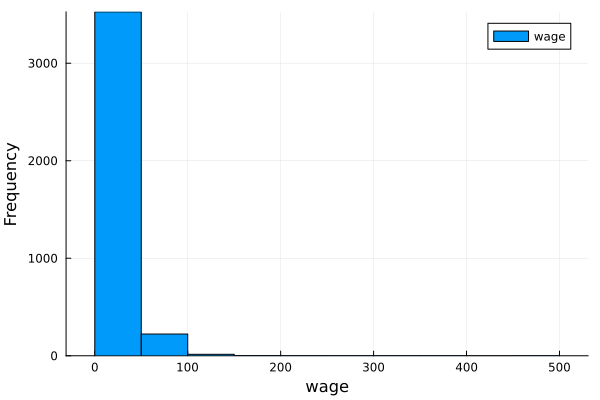

In [121]:
main_variables = ["wage", "lwage", "sex", "scl", "clg", "ad", "exp1"]

# Histograma de la primera variable principal
histogram(data_filtered[!, main_variables[1]], bins = 20, xlabel = main_variables[1], ylabel = "Frequency", label = "wage")


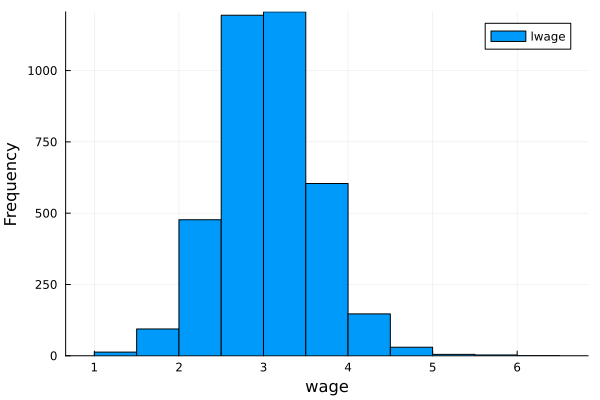

In [122]:

# Histograma de la primera variable principal
histogram(data_filtered[!, main_variables[2]], bins = 20, xlabel = main_variables[1], ylabel = "Frequency", label = "lwage")


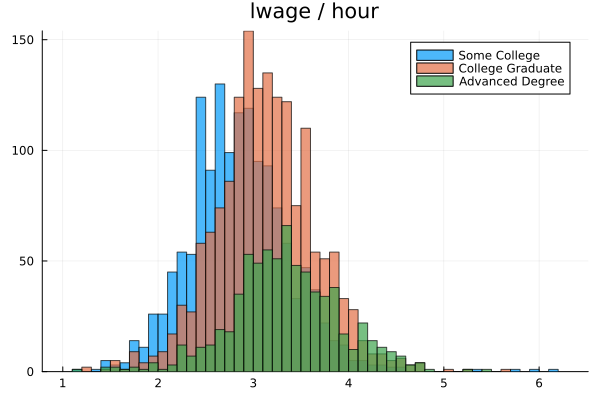

In [123]:
cat = ["scl", "clg",  "ad"] 
labels_cat = ["Some College", "College Graduate",  "Advanced Degree"]

histogram()
for (i, j) in enumerate(cat)
    _ref_data = filter(Symbol(j) => ==(1), data_filtered)
    histogram!(
        _ref_data.lwage
        , alpha = 0.7,
        label = labels_cat[i]
        , bins =50
     )
end
title!("lwage / hour")
# _ref_data

In [124]:
label_sexs = ["Male", "Female"]
plot_d = []

for (i_cat, cat_col) in enumerate(cat)
    plot()
    for (i_sex, label_sex) in enumerate(label_sexs)
        _ref_data = filter(Symbol(cat_col) => ==(1), data_filtered)
        filter!(row -> row.sex == i_sex - 1, _ref_data)
        histogram!(
            _ref_data.lwage, 
            alpha = 0.5,
            label = label_sex
        )
        
    end
    push!(plot_d, title!(labels_cat[i_cat]))
end

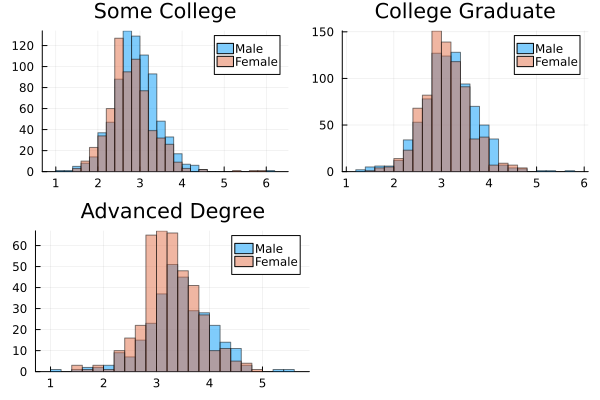

In [125]:
plot(plot_d[1], plot_d[2], plot_d[3], layout = [2, 2])

# Estimation

In [146]:
result_df = DataFrame()
function tbl_coef(model)
    a = GLM.coeftable( model)
    return DataFrame(a)
end
base_model = lm(@formula(lwage ~ sex), data_filtered)
append!(result_df, tbl_coef(base_model))
base_model


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

lwage ~ 1 + sex

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)   3.09945    0.0128503  241.20    <1e-99   3.07425    3.12464
sex          -0.075032   0.0183738   -4.08    <1e-04  -0.111056  -0.0390084
───────────────────────────────────────────────────────────────────────────

In [147]:
flex = @formula(lwage ~ sex + (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+occ2+ind2+mw+so+we))
control_model = lm(flex , data_filtered)
append!(result_df, tbl_coef(control_model))
control_model


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

lwage ~ 1 + sex + exp1 + exp2 + exp3 + exp4 + shs + hsg + scl + clg + occ2 + ind2 + mw + so + we + exp1 & shs + exp1 & hsg + exp1 & scl + exp1 & clg + exp1 & occ2 + exp1 & ind2 + exp1 & mw + exp1 & so + exp1 & we + exp2 & shs + exp2 & hsg + exp2 & scl + exp2 & clg + exp2 & occ2 + exp2 & ind2 + exp2 & mw + exp2 & so + exp2 & we + exp3 & shs + exp3 & hsg + exp3 & scl + exp3 & clg + exp3 & occ2 + exp3 & ind2 + exp3 & mw + exp3 & so + exp3 & we + exp4 & shs + exp4 & hsg + exp4 & scl + exp4 & clg + exp4 & occ2 + exp4 & ind2 + exp4 & mw + exp4 & so + exp4 & we

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error       t  Pr(>|t|)      Lower 95%     Upper 95%
─────────────────────────────────────────────────────

<!-- filter data -->


In [148]:
flex_y = @formula(lwage ~ (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+occ2+ind2+mw+so+we))
flex_d = @formula(sex ~ (exp1+exp2+exp3+exp4) * (shs+hsg+scl+clg+occ2+ind2+mw+so+we))

t_Y = residuals(lm(flex_y, data_filtered))
t_D = residuals(lm(flex_d, data_filtered))
data_res = DataFrame(t_Y = t_Y, sex = t_D )
partial_fit = lm(@formula(t_Y ~ sex), data_res)
append!(result_df, tbl_coef(partial_fit))
partial_fit


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

t_Y ~ 1 + sex

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  -5.17664e-15  0.00745181  -0.00    1.0000  -0.01461    0.01461
sex          -0.0676339    0.0169281   -4.00    <1e-04  -0.100823  -0.0344448
─────────────────────────────────────────────────────────────────────────────

In [149]:

new_cols = ["name", "coef", "std", "t", "p", "ll", "ul"]
columns_dict = Dict(zip(names(result_df), new_cols))
rename!(result_df, columns_dict)
result_df = filter(row -> row[:name] == "sex", result_df)
result_df.type = ["Basic", "Controled", "Partial Fit"]
result_df

Row,name,coef,std,t,p,ll,ul,type
,String,Float64,Float64,Float64,Float64,Float64,Float64,String
1,sex,-0.075032,0.0183738,-4.08363,4.52571e-5,-0.111056,-0.0390084,Basic
2,sex,-0.0676339,0.0174765,-3.86999,0.0001108,-0.101899,-0.0333689,Controled
3,sex,-0.0676339,0.0169281,-3.99536,6.5829e-5,-0.100823,-0.0344448,Partial Fit


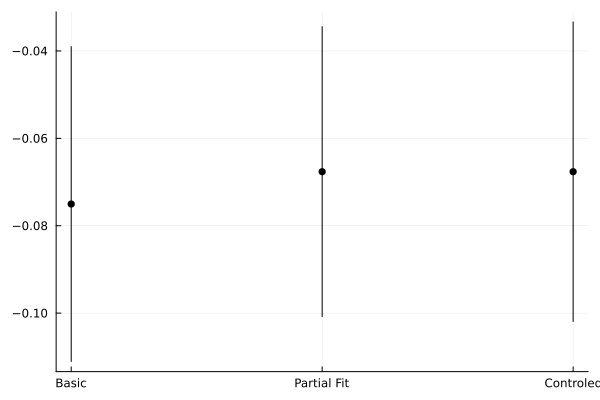

In [151]:
plot()
function plot_ci(type, data = result_df)
    a = filter(row -> row[:type] == type, result_df)
    coef = a.coef
    ul = a.ul
    ll = a.ll
    scatter!([type], [coef], label = "", color = "black")
    plot!([type, type], [ul[1], ll[1]], color = "black", label = "")
end
plot_ci("Basic")
plot_ci("Partial Fit")
plot_ci("Controled")


# Replication
## Male

In [131]:

type_education = [:clg, :hsg]
MODEL = @formula( lwage ~ sex + (exp1+exp2+exp3+exp4)*(scl+clg+ad+occ2+ind2+mw+so+we))

type_edu = :clg
sex = 1
function predict_values(type_edu, sex, data = data)
    ref_data = filter(row -> row[type_edu] == 1 && row[:sex] == sex, data)
    mm = lm(MODEL, ref_data)
    ref_data.predict = predict(mm, ref_data)
    ref_data
    # filter(row -> row[:clg] == 1, data)

    gdf = groupby(ref_data, :exp1)
    result_df = combine(gdf, :lwage => mean, :predict => mean)
    return result_df
end
clg_mean = predict_values(:clg, 0)
hsg_mean = predict_values(:hsg, 0);
intersection = intersect(clg_mean.exp1, hsg_mean.exp1);

In [132]:
hsg_in_gap = filter(row -> in(row[:exp1], intersection), hsg_mean)
clg_in_gap = filter(row -> in(row[:exp1], intersection), clg_mean)

function gap_values(col, df1, df2)
    result = df1[!, col]  - df2[!, col]
    return result
end
fitted_gap = gap_values(:predict_mean, clg_in_gap, hsg_in_gap)
actual_gap = gap_values(:lwage_mean, clg_in_gap, hsg_in_gap)
std_gap = std(actual_gap)
ll = actual_gap .- std_gap
ul = actual_gap .+ std_gap;

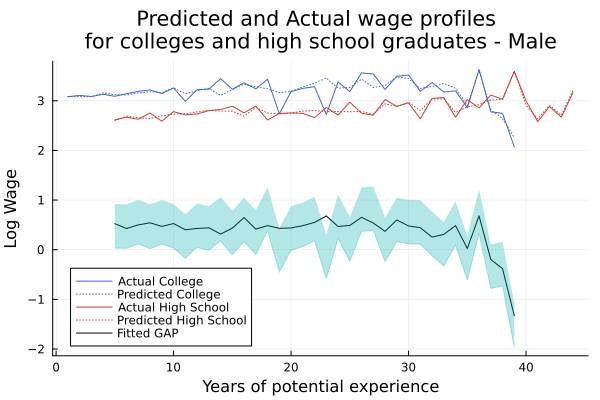

In [133]:
colors = ["#4063D8", "#CB3C33"]
plot(clg_mean.exp1, clg_mean.lwage_mean   , label = "Actual College", color = colors[1])
plot!(clg_mean.exp1, clg_mean.predict_mean, label = "Predicted College", color = colors[1], linestyle=:dot)
plot!(hsg_mean.exp1, hsg_mean.lwage_mean  , label = "Actual High School", color = colors[2])
plot!(hsg_mean.exp1, hsg_mean.predict_mean, label = "Predicted High School", color = colors[2], linestyle=:dot)
plot!(intersection, fitted_gap            , label = "Fitted GAP", color = "black")
plot!(intersection, ll, fillrange = ul, alpha = 0.3, label = "")
title!("Predicted and Actual wage profiles \nfor colleges and high school graduates - Male\n", fontsize = 2)
Plots.xlabel!("Years of potential experience")
Plots.ylabel!("Log Wage")

## Female

In [134]:

type_education = [:clg, :hsg]
MODEL = @formula( lwage ~ sex + (exp1+exp2+exp3+exp4)*(scl+clg+ad+occ2+ind2+mw+so+we))

type_edu = :clg
sex = 1
function predict_values(type_edu, sex, data = data)
    ref_data = filter(row -> row[type_edu] == 1 && row[:sex] == sex, data)
    mm = lm(MODEL, ref_data)
    ref_data.predict = predict(mm, ref_data)
    ref_data
    # filter(row -> row[:clg] == 1, data)

    gdf = groupby(ref_data, :exp1)
    result_df = combine(gdf, :lwage => mean, :predict => mean)
    return result_df
end
clg_mean = predict_values(:clg, sex)
hsg_mean = predict_values(:hsg, sex);
intersection = intersect(clg_mean.exp1, hsg_mean.exp1);
# ################
hsg_in_gap = filter(row -> in(row[:exp1], intersection), hsg_mean)
clg_in_gap = filter(row -> in(row[:exp1], intersection), clg_mean)

function gap_values(col, df1, df2)
    result = df1[!, col]  - df2[!, col]
    return result
end
fitted_gap = gap_values(:predict_mean, clg_in_gap, hsg_in_gap)
actual_gap = gap_values(:lwage_mean, clg_in_gap, hsg_in_gap)
std_gap = std(actual_gap)
ll = actual_gap .- std_gap
ul = actual_gap .+ std_gap;

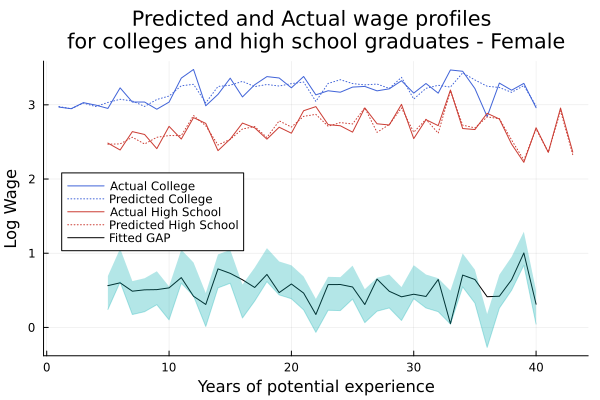

In [135]:
colors = ["#4063D8", "#CB3C33"]
plot(clg_mean.exp1, clg_mean.lwage_mean   , label = "Actual College", color = colors[1], leg= :left)
plot!(clg_mean.exp1, clg_mean.predict_mean, label = "Predicted College", color = colors[1], linestyle=:dot)
plot!(hsg_mean.exp1, hsg_mean.lwage_mean  , label = "Actual High School", color = colors[2])
plot!(hsg_mean.exp1, hsg_mean.predict_mean, label = "Predicted High School", color = colors[2], linestyle=:dot)
plot!(intersection, fitted_gap            , label = "Fitted GAP", color = "black")
plot!(intersection, ll, fillrange = ul, alpha = 0.3, label = "")
title!("Predicted and Actual wage profiles \nfor colleges and high school graduates - Female\n", fontsize = 2)
Plots.xlabel!("Years of potential experience")
Plots.ylabel!("Log Wage")


# Cross Validation

In [136]:
data = CSV.read("../../../data/wage2015_subsample_inference.csv", DataFrame)
select!(data, Not([:rownames, :wage]));
n = size(data)[1]

5150

In [137]:
alphas = [0.1, 0.2,0.3,0.4,0.5]
train_size = 0.7
i_folds = []
for i in 1:5
    i_perm = randperm(n)
    n_train = Int(ceil(train_size * n))
    n_test = n - n_train
    train_i = i_perm[1:n_train] 
    test_i = i_perm[n_train+1:end] 
    i_values = [[train_i, test_i]]
    append!(i_folds, i_values)
end
i_folds


5-element Vector{Any}:
 [[1432, 3026, 3601, 2090, 2474, 292, 630, 2887, 3774, 3265  …  5051, 3141, 281, 4974, 4160, 2959, 43, 711, 3493, 2520], [1684, 3927, 4128, 1408, 3080, 3740, 742, 1061, 1428, 1805  …  3348, 4060, 3610, 5025, 1927, 2892, 1149, 3222, 1771, 5027]]
 [[365, 3315, 4315, 1278, 4082, 296, 4246, 3088, 1719, 2787  …  3929, 2587, 1247, 2422, 3773, 2645, 1787, 221, 1443, 4162], [4095, 613, 2348, 460, 2173, 723, 4650, 481, 1261, 1217  …  405, 4520, 3852, 1394, 182, 4180, 2394, 1303, 3763, 2402]]
 [[2490, 4655, 3625, 2460, 4359, 4420, 766, 4208, 3720, 401  …  2552, 1878, 205, 2896, 2921, 4278, 2209, 3865, 4701, 4327], [631, 1439, 3204, 1649, 3416, 4648, 4249, 2360, 4575, 152  …  3463, 1766, 2597, 1053, 3967, 2341, 1318, 702, 3288, 1751]]
 [[2795, 5115, 368, 3010, 3936, 3837, 3742, 703, 2065, 3730  …  145, 3316, 2223, 2890, 2323, 976, 1918, 4949, 3247, 997], [1275, 2331, 12, 3086, 3351, 3723, 101, 4902, 2676, 3216  …  2589, 2167, 4723, 1912, 1241, 98, 4571, 312, 2528, 1240]]
 [

In [138]:
x_values = sum(term.(names(data[!, Not([:lwage])])))
alpha = 0.1
_i_fold = 1 
result_df = DataFrame()

for _i_fold in i_folds
    for alpha in alphas

        i_train, i_test = _i_fold
        data_train = data[i_train, :]
        data_test = data[i_test, :]

        lasso = fit(LassoModel, term(:lwage) ~ x_values, data_train; α = alpha)
        y_predict = predict(lasso, data_test)
        y_real = data_test[!, "lwage"]
        mse = mean((y_predict .- y_real).^2)

        result = DataFrame(alpha = alpha, mse = mse)
        append!(result_df, result)

    end
end
result_df[1:4, :]

Row,alpha,mse
,Float64,Float64
1,0.1,0.249284
2,0.2,0.249297
3,0.3,0.249295
4,0.4,0.249287


In [139]:
gdf_result = groupby(result_df, :alpha)
rst = combine(gdf_result, :mse => mean)

Row,alpha,mse_mean
,Float64,Float64
1,0.1,0.251874
2,0.2,0.251887
3,0.3,0.251871
4,0.4,0.251886
5,0.5,0.251888


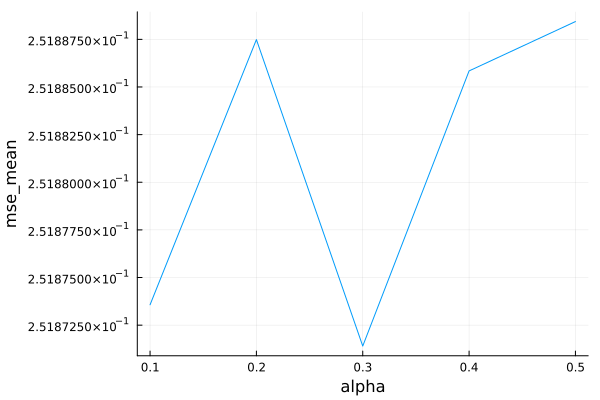

In [140]:
plot(rst.alpha, rst.mse_mean, xlabel="alpha", ylabel="mse_mean", label="")

In [141]:
sort!(rst, :mse_mean)
opt_alpha = rst[1, :alpha]

0.3

In [142]:
# final result
lasso = fit(LassoModel, term(:lwage) ~ x_values, data; α = opt_alpha)

y_predict = predict(lasso, data)
y_real = data[!, "lwage"]
mse = mean((y_predict .- y_real).^2)

0.2483723254801529

In [143]:
DataFrame(y_pred = y_predict, y = y_real)[1:12, :]

Row,y_pred,y
,Float64?,Float64
1,2.9558,2.26336
2,3.40949,3.8728
3,2.84421,2.40313
4,3.60671,2.63493
5,3.17009,3.36198
6,3.04197,2.46222
7,2.65444,2.95651
8,2.88205,2.95651
9,2.74789,2.48491
